## Importacion de librerias

#### Sistema

In [1]:
import os
import sys
sys.path.append('../')

#### Exploración de datos y visualización

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

#### Manejo de Rasters

In [3]:
import rasterio as rio

#### Entrenamiento

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

2023-09-27 21:44:22.247526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 21:44:22.520394: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-27 21:44:23.190086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/theend/miniconda3/envs/soil-env/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/theend/miniconda3/envs/soil-env/lib/:/usr/local/cuda-11.8/lib64:
2023-09-27 21:44:23.190169: W tensorflow/stream_executor/p

In [5]:
from src.layers.utilities import plot_merge_class, process_data_points, locations_of_pixels, plot_confusion_matrix

#### Establecer semilla aleatoria para la reproductibilidad

In [6]:
# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
random.seed(RANDOM_SEED)

# Set random state for NumPy
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

#### Verificar GPU

In [7]:
def print_info():
    tf_version = tf.__version__
    gpus = [x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    cuda_version = tf.sysconfig.get_build_info()['cuda_version']
    cudnn_version = tf.sysconfig.get_build_info()['cudnn_version']
    
    print('Versión de TensorFlow: {}'.format(tf_version))
    print('GPU: {}'.format(gpus))
    print('Versión Cuda: {}'.format(cuda_version))
    print('Versión Cudnn: {}\n'.format(cudnn_version))

print_info()

Versión de TensorFlow: 2.10.1
GPU: ['device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6']
Versión Cuda: 11.2
Versión Cudnn: 8



2023-09-27 21:44:24.643817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 21:44:24.663005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-27 21:44:24.692488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-27 21:44:24.692763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Entrenamiento Modelo

In [8]:
from src.layers.dict_class import LandCoverClassDict
dict_class = LandCoverClassDict()

#### Diccionarios e identificadores de clase

In [9]:
class_names = dict_class.get_landsat_dictionary()
class_names

{0: 'Sin Clasificar',
 1: 'Bosque',
 2: 'Cuerpo de Agua',
 3: 'Otras Tierras',
 4: 'Tierra Agropecuaria',
 5: 'Vegetacion Arbustiva y Herbacea',
 6: 'Zona Antropica'}

In [10]:
colors_class = dict_class.get_colors_dictionary()
colors_class

{0: (0, 0, 0),
 1: (62, 178, 49),
 2: (0, 0, 251),
 3: (122, 125, 74),
 4: (245, 106, 0),
 5: (255, 165, 81),
 6: (255, 0, 0)}

### Procesamiento de la imagen de etiquetas NLDC

In [11]:
from src.controllers.raster import RasterController
raster = RasterController()

#### Configuracion de directiorios de los mosaicos (labels, rasters)

In [12]:
label_path = '../data/images/processed/labels/landsat/landcover_ecuador_v1.tif'
rasters_path = '../data/images/processed/products/landsat/toa/2013-2015/'

#### Abrir Mosaico

In [13]:
dataset_labels = raster.open_raster(raster=label_path)

Number of bands in the image: 1

Image size: 25540 rows x 34000 columns

Raster driver: GTiff

Image projection:
 EPSG:32717



#### Lectura de mosaico

In [14]:
labels_image = raster.read_raster(dataset_labels)
labels_image.shape

(1, 25540, 34000)

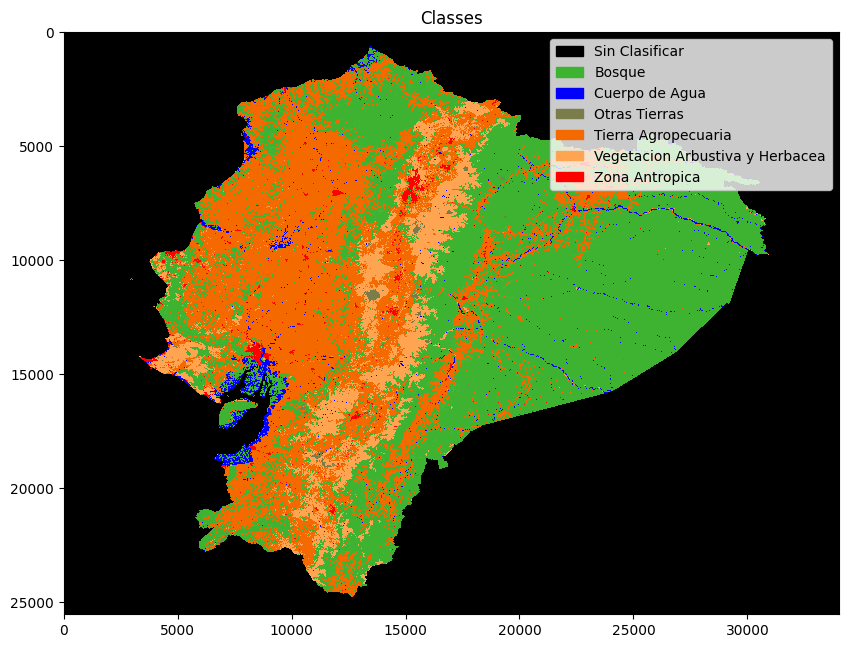

In [15]:
plot_merge_class(labels_image, colors_class, class_names)

#### Generar datos de entrenamiento balanceados

In [16]:
from src.controllers.pixel import PixelController
pixel = PixelController(label_dataset=dataset_labels)

In [17]:
landsat_datasets =  [rio.open(f'{rasters_path}/{raster}') for raster in os.listdir(rasters_path)]

In [18]:
train_pixels = pixel.generate_training_pixels(
    image_datasets=landsat_datasets,
    train_count=20000,
    merge=True
)

Train count per dataset:  2858
Points per class:  408


Processing << Zona Antropica >>: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]                 


#### Data Validation
- Balanced and accurate dataset.
- Actual pixel locations.

In [ ]:
label_locations = process_data_points(train_pixels=train_pixels, landsat_datasets=landsat_datasets, dataset_labels=dataset_labels)

In [ ]:
locations_of_pixels(labels=labels_image, locations=label_locations, colors=colors_class)

In [ ]:
import gc
gc.collect()

## Probando el generador de datos

In [ ]:
from src.controllers.tile import TileController

In [ ]:
#%run "/home/theend/Documentos/Develop/Python/Jupyter/soil_desertification/src/controllers/tile.py"

from pyproj import Proj,transform
import math
from rasterio.windows import Window
from rasterio.plot import reshape_as_image

def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    # this is a keras compatible data generator which generates data and labels on the fly
    # from a set of pixel locations, a list of image datasets, and a label dataset

    c = r = 0
    i = 0

    label_proj = Proj(label_dataset.crs)
    l8_proj = Proj(l8_image_datasets[0].crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)

    while True:
        # take one off because we don't want the QA band
        image_batch = np.zeros(
            (batch_size, tile_height, tile_width, band_count-1))
        label_batch = np.zeros((batch_size, class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i = 0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(
                1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0:  # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile:
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                # print('wrong shape')
                # print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7, :, :], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                # print('Found some cloud.')
                # print(tile[7,:,:])
                pass
            else:
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile) - 982.5) / 1076.5

                # get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    x, y = transform(l8_proj, label_proj, x, y)

                # reference gps in label_image
                row, col = label_dataset.index(x, y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = dict_class.merge_classes(label_dataset.read(
                    1, window=window, masked=False, boundless=True), "landsat")
                label = data[0, 0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
                    print(b)
        yield (image_batch, label_batch)
print('tile_generator code ready!')

In [ ]:
im_batch = None

count = 0
for (im, label) in  next(TileController(landsat_datasets, dataset_labels, 128, 128, train_pixels, 10)):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

In [ ]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

In [ ]:
def plot_images_with_labels(image_batch, label_batch, class_names):
    num_images = image_batch.shape[0]
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.62 * 10, 10))

    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols

        axes[row, col].imshow(normalize(image_batch[i, :, :, 3:6]))
        axes[row, col].set_title(class_names[np.argmax(label_batch[i])])

    # Remove any empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

In [ ]:
plot_images_with_labels(im_batch, label_batch, class_names)

#### Generar conjunto de datos de entrenamiento de 1x1 azulejos para scikit-learn para visualizar los datos

In [ ]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in next(TileController(images=landsat_datasets, label=dataset_labels, height=1, width=1, pixel_locations=train_pixels, batch_size=sample_size)):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

#### Redimencionar 
Remodelar porque scikit-learn necesita datos en formato `(muestras, bandas)`:

In [ ]:
im_batch[0, :, :, :]

In [ ]:
im_batch_reshaped = im_batch.reshape(sample_size, 7)
im_batch_reshaped[0]

#### Visualizar Firmas Espectrales

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# numbers 1-8
band_count = np.arange(1, 8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a titleA
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

## Arquitectura, entrenamiento y validación de la RNN

In [ ]:
from keras.models import Sequential
from keras.layers import (
    Bidirectional,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    LSTM,
    MaxPooling2D,
    Reshape,
    BatchNormalization,
    Activation,
)
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

#### Establecer los hiperparámetros

In [ ]:
epochs = 50
batch_size = 25
dropout_rate = 0.3
learning_rate = 0.001
steps_division_factor = 1
num_classes = len(class_names)

# dimensiones de la imagen de entrada
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

#### Arquitectura CNN

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Agregamos una capa de Reshape para convertir la salida en 3D
model.add(Reshape((1, 1024)))

# Agregamos dos capas Bidirectional LSTM
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Regularización L2 en capa densa
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Regularización L2 en capa densa
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(num_classes))
model.add(Activation('softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

##### Divida los datos en entrenamiento y validación

In [ ]:
train_to_val_ratio = 0.7
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".format(n_training=len(train_px), n_val=len(val_px)))

##### Tensforflow Callbacks

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.80):
            print("\n Se ha alcanzado el umbral PRESICION. Entrenamiento detenido.....")
            self.model.stop_training = True

In [ ]:
early_stopping = EarlyStopping()
tensorboard = TensorBoard(log_dir='../reports/landsat/v1/logs')
checkpoint = ModelCheckpoint('../models/v1/landsat.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    next(TileController(landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size)),
    steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
    validation_data=next(
    TileController(landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size)),
    validation_steps=len(val_px) // batch_size,
    callbacks=[checkpoint, early_stopping, tensorboard]
)

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Comprobar el resultado con los datos de validación

In [ ]:
predictions = model.predict(
    next(
        TileController(
            landsat_datasets, dataset_labels, tile_side, tile_side, val_px, batch_size
        )
    ),
    steps=len(val_px) // batch_size,
    verbose=1,
)

In [ ]:
eval_generator = next(
    TileController(
        landsat_datasets, dataset_labels, tile_side, tile_side, val_px, batch_size=1
    )
)

In [ ]:
predictions.shape

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Trazar matriz de confusión no normalizada

In [ ]:
plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Unnormalized',
)

#### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Normalized',
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

### Comprobar el resultado con los datos de entrenamiento

In [ ]:
predictions = model.predict(
    next(
        TileController(
            landsat_datasets, dataset_labels, tile_side, tile_side, train_px, batch_size
        )
    ),
    steps=len(train_px) // batch_size,
    verbose=1,
)

In [ ]:
predictions = model.predict(
    next(
        TileController(
            landsat_datasets, dataset_labels, tile_side, tile_side, train_px, batch_size
        )
    ),
    steps=len(train_px) // batch_size,
    verbose=1,
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Trazar matriz de confusión no normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Unnormalized'
)

#### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Normalized',
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

In [ ]:
print("IPython Notebook execution completed!")